In [1]:
import pandas as pd
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('reviews.csv')
df = df.sample(frac=1,random_state=42).reset_index(drop=True)
df = df.iloc[:10000,:]
df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,25493223,747265132,2021-04-10,128336747,Christina,"Perfect & Beautiful apartment, so conveniently..."
1,47762390,564676020929970681,2022-02-17,112816618,Mativenga,Clean house
2,832754,244032560,2018-03-18,100879041,April,"Great location close to public transport, clos..."
3,28855538,415906975,2019-02-23,74737595,Tim,.
4,48421685,571909760706937673,2022-02-27,98408038,Natalie,Very clean house and comfy stay for two families.
...,...,...,...,...,...,...
9995,52865248,1019860293084674024,2023-11-07,61722856,HyeRim,"Good location, around 15min walk to the circul..."
9996,47785856,905431841620639498,2023-06-03,450881336,Roselle,Great place to stay! Host was very helpful and...
9997,44621877,739768073,2021-03-16,100464042,Andrew,"Great spot, lovely outlook over Bondi and all ..."
9998,45107691,593023065654393060,2022-03-29,55488295,Amelia,"Caroline, was fantastic and everything was spo..."


In [9]:
df.to_csv('reviews_1.csv')
df =df.iloc[:1000,:]
df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,25493223,747265132,2021-04-10,128336747,Christina,"Perfect & Beautiful apartment, so conveniently..."
1,47762390,564676020929970681,2022-02-17,112816618,Mativenga,Clean house
2,832754,244032560,2018-03-18,100879041,April,"Great location close to public transport, clos..."
3,28855538,415906975,2019-02-23,74737595,Tim,.
4,48421685,571909760706937673,2022-02-27,98408038,Natalie,Very clean house and comfy stay for two families.
...,...,...,...,...,...,...
995,24706843,766053001,2021-06-04,93404706,Kate,Gorgeous one bedroom place in the heart of Dar...
996,827093084214711885,1096747012552454987,2024-02-22,96756337,Travis,A very beautiful Airbnb space below the main h...
997,571271131032199114,982967221263722185,2023-09-18,153331884,Kenji,Joanne and Julian were great hosts. Their plac...
998,30048290,793052643560729657,2022-12-29,12064567,Roshni,Amazing location & views. <br/>But the second ...


In [2]:
df = pd.read_csv('reviews_1.csv')
df = df.dropna()
df.shape

(9999, 7)

In [3]:
# 假设df是你的DataFrame，text_column是包含评论的列
# 预处理文本
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    return words

df['processed_text'] = df['comments'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
df.head(5)

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,processed_text
0,0,25493223,747265132,2021-04-10,128336747,Christina,"Perfect & Beautiful apartment, so conveniently...","[perfect, beautiful, apartment, conveniently, ..."
1,1,47762390,564676020929970681,2022-02-17,112816618,Mativenga,Clean house,"[clean, house]"
2,2,832754,244032560,2018-03-18,100879041,April,"Great location close to public transport, clos...","[great, location, close, public, transport, cl..."
3,3,28855538,415906975,2019-02-23,74737595,Tim,.,[]
4,4,48421685,571909760706937673,2022-02-27,98408038,Natalie,Very clean house and comfy stay for two families.,"[very, clean, house, comfy, stay, two, families]"


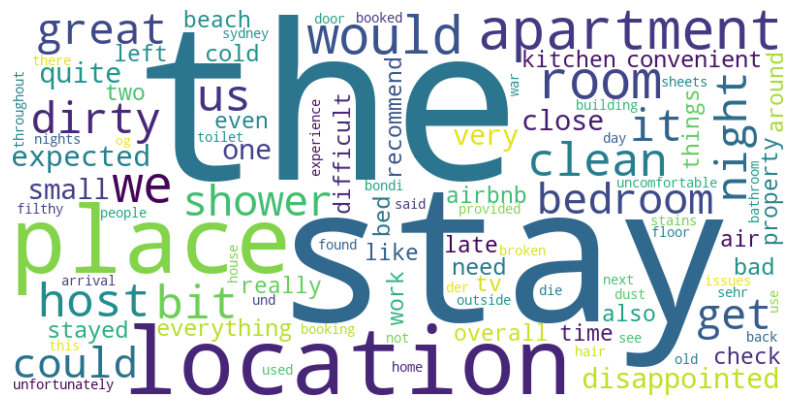

In [16]:
# 情感分析筛选积极 - 消极 评论
df['sentiment'] = df['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)
positive_reviews = df[df['sentiment'] < 0]['processed_text']

all_positive_reviews = [' '.join(text) for text in positive_reviews]
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_positive_reviews)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
tfidf_scores_dict = dict(zip(feature_names, tfidf_scores))

# 使用WordCloud显示关键词
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(tfidf_scores_dict)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 主题建模
dictionary = corpora.Dictionary(positive_reviews)
corpus = [dictionary.doc2bow(text) for text in positive_reviews]
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

# 形容词专题

In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter

def extract_adjectives(texts):
    stopwords_list = set(stopwords.words('english'))  # 加载停用词列表
    adjectives = []

    for text in texts:
        # 分词和词性标注
        tokens = word_tokenize(text)
        tagged_tokens = pos_tag(tokens)

        # 提取形容词
        for word, tag in tagged_tokens:
            if tag == 'JJ' and word.lower() not in stopwords_list:
                adjectives.append(word.lower())

    return adjectives

# 假设 all_positive_reviews 是所有积极评论的合并文本列表
adjectives = extract_adjectives(all_positive_reviews)


In [18]:
adjective_counts = Counter(adjectives)
most_common_adjectives = adjective_counts.most_common(50)  # 获取频率最高的10个形容词

df_adjectives = pd.DataFrame(most_common_adjectives, columns=['Adjective', 'Frequency'])
df_adjectives

,Adjective,Frequency
0,bad,16
1,great,15
2,clean,15
3,small,14
4,dirty,10
5,stay,9
6,difficult,9
7,overall,8
8,filthy,8
9,uncomfortable,8


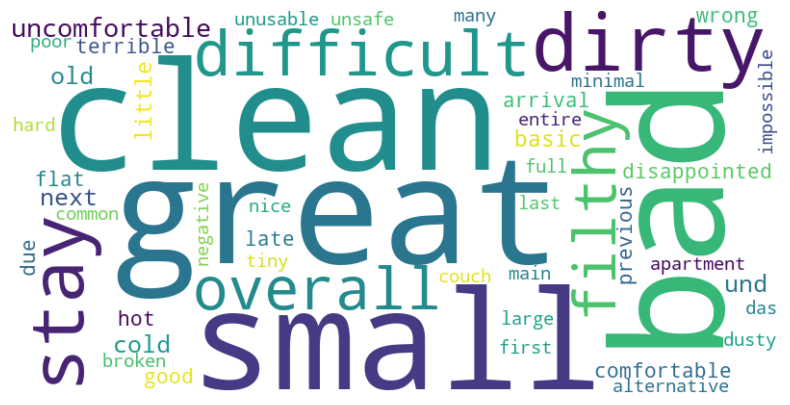

In [19]:
# 假设df_adjectives已经包含了形容词及其频率
adjectives_dict = dict(zip(df_adjectives['Adjective'], df_adjectives['Frequency']))

# 创建词云对象
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(adjectives_dict)

# 使用matplotlib显示词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不显示坐标轴
plt.show()
